In [1]:
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as rfr
from xgboost import XGBClassifier as xgb


In [2]:
cta = pd.read_csv('CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
cta.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,01/01/2001,U,290
1,40020,Harlem-Lake,01/01/2001,U,633
2,40030,Pulaski-Lake,01/01/2001,U,483
3,40040,Quincy/Wells,01/01/2001,U,374
4,40050,Davis,01/01/2001,U,804


In [3]:
import datetime

def mydate(mystr):
    m,d,y = [int(i) for i in mystr.split('/')]
    return datetime.datetime(y,m,d)

# decimalized month for monthly plotting
def decmo(mydate):
    lens = [31,28 + (mydate.year % 4 == 0),31,30,31,30,31,31,30,31,30,31]
    # all divisible by four are leap years, last exception was 1900
    return mydate.month + mydate.day/lens[mydate.month - 1]


In [4]:
cta['date'] = cta['date'].apply(mydate,1)
cta['day'] = cta['date'].apply(lambda x: x.day)
cta['month'] = cta['date'].apply(lambda x: x.month)
cta['year'] = cta['date'].apply(lambda x: x.year)
cta['weekday'] = cta['date'].apply(lambda x: ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][x.weekday()])
cta['decmo'] = cta['date'].apply(decmo,1)
cta.head()

,station_id,stationname,date,daytype,rides,day,month,year,weekday,decmo
0,40010,Austin-Forest Park,2001-01-01,U,290,1,1,2001,Mon,1.032258
1,40020,Harlem-Lake,2001-01-01,U,633,1,1,2001,Mon,1.032258
2,40030,Pulaski-Lake,2001-01-01,U,483,1,1,2001,Mon,1.032258
3,40040,Quincy/Wells,2001-01-01,U,374,1,1,2001,Mon,1.032258
4,40050,Davis,2001-01-01,U,804,1,1,2001,Mon,1.032258


Everything is self explanatory but daytype

In [5]:
cta.daytype.value_counts()

W    565419
U    128848
A    115059
Name: daytype, dtype: int64

I want to find out what U, A, W mean. I suspect they have to do with the day of the week.

In [6]:
ctaw = cta[cta.daytype == 'W']
ctaw.weekday.value_counts()

Tue    114625
Wed    114625
Fri    114328
Thu    112335
Mon    109506
Name: weekday, dtype: int64

In [7]:
ctaa = cta[cta.daytype == 'A']
ctaa.weekday.value_counts()

Sat    115059
Name: weekday, dtype: int64

In [8]:
ctau = cta[cta.daytype == 'U']
ctau.weekday.value_counts()

Sun    115617
Mon      6117
Thu      3272
Fri      1282
Wed       998
Tue       996
Sat       566
Name: weekday, dtype: int64

Judging from these distributions, it looks like W are normal weekdays, A are normal saturdays, U are Sundays and holidays/sports games. To make sure, I'll look at the non-Sunday U values.

In [9]:
ctauns = ctau[ctau.weekday != 'Sun']
ctauns = ctauns.drop_duplicates(subset = ['date','stationname'])
#this will get station-specific drops
ctauns.head()

,station_id,stationname,date,daytype,rides,day,month,year,weekday,decmo
0,40010,Austin-Forest Park,2001-01-01,U,290,1,1,2001,Mon,1.032258
1,40020,Harlem-Lake,2001-01-01,U,633,1,1,2001,Mon,1.032258
2,40030,Pulaski-Lake,2001-01-01,U,483,1,1,2001,Mon,1.032258
3,40040,Quincy/Wells,2001-01-01,U,374,1,1,2001,Mon,1.032258
4,40050,Davis,2001-01-01,U,804,1,1,2001,Mon,1.032258


(1, 13)

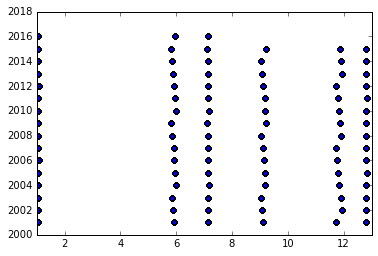

In [10]:
plt.scatter(ctauns.decmo,ctauns.year)
plt.xlim(1,13)

The non-Sunday U days are around New Years, Memorial Day, July 4, Labor Day, Thanksgiving, and Christmas.

Note also that U is not station-specific -- all these U values are constant for all stations.

In [11]:
cta.stationname.unique()

array(['Austin-Forest Park', 'Harlem-Lake', 'Pulaski-Lake', 'Quincy/Wells',
       'Davis', "Belmont-O'Hare", 'Jackson/Dearborn', 'Sheridan',
       'Damen-Brown', 'Morse', '35th/Archer', '51st', 'Skokie',
       'Pulaski-Cermak', 'LaSalle/Van Buren', 'Ashland-Lake',
       'Oak Park-Forest Park', 'Sox-35th-Dan Ryan', 'Randolph/Wabash',
       'Damen-Cermak', 'Western-Forest Park', 'Cumberland', '79th',
       'Kedzie-Homan-Forest Park', 'State/Lake', 'Main', 'Central-Lake',
       'Ashland/63rd', 'Indiana', 'Western-Orange', 'Division/Milwaukee',
       'Grand/State', 'Berwyn', 'UIC-Halsted', 'Southport',
       'Washington/Dearborn', 'Clark/Lake', 'Forest Park', 'Noyes',
       'Cicero-Cermak', 'Clinton-Forest Park', 'California-Cermak',
       '95th/Dan Ryan', 'Merchandise Mart', 'Racine', 'Cicero-Lake',
       'Grand/Milwaukee', 'Washington/State', 'Garfield-South Elevated',
       'Foster', 'Diversey', 'Wilson', "Irving Park-O'Hare",
       'Jackson/State', 'California/Milwaukee',

In [12]:
cta.station_id.unique()

array([40010, 40020, 40030, 40040, 40050, 40060, 40070, 40080, 40090,
       40100, 40120, 40130, 40140, 40150, 40160, 40170, 40180, 40190,
       40200, 40210, 40220, 40230, 40240, 40250, 40260, 40270, 40280,
       40290, 40300, 40310, 40320, 40330, 40340, 40350, 40360, 40370,
       40380, 40390, 40400, 40420, 40430, 40440, 40450, 40460, 40470,
       40480, 40490, 40500, 40510, 40520, 40530, 40540, 40550, 40560,
       40570, 40580, 40590, 40600, 40610, 40630, 40640, 40650, 40660,
       40670, 40680, 40690, 40700, 40710, 40720, 40730, 40740, 40750,
       40760, 40770, 40780, 40790, 40800, 40810, 40820, 40830, 40840,
       40850, 40870, 40880, 40890, 40900, 40910, 40920, 40930, 40940,
       40960, 40970, 40980, 40990, 41000, 41010, 41020, 41030, 41040,
       41050, 41060, 41070, 41080, 41090, 41120, 41130, 41140, 41150,
       41160, 41170, 41180, 41190, 41200, 41210, 41220, 41230, 41240,
       41250, 41260, 41270, 41280, 41290, 41300, 41310, 41320, 41330,
       41340, 41350,

I just want to work with stations active the whole time, so I look at those active on the first and last day

In [13]:
old = cta[cta.date == datetime.datetime(2001,1,1)]
old_stations = set(old.stationname.tolist())
new = cta[cta.date == datetime.datetime(2016,7,31)]
new_stations = set(new.stationname.tolist())
good_stations = list(old_stations.intersection(new_stations))

Next I get yearly totals, both overall and by station, and then calculate the percentage of yearly ridership that each station represents.

In [14]:
cta = cta[cta.daytype == 'U']

In [15]:
ytotals = pd.DataFrame(cta.groupby(['year','month'], as_index = False)['rides'].mean())
ytotals['stationname'] = ['Total']*len(ytotals)
ytotals.head()

,year,month,rides,stationname
0,2001,1,968.602837,Total
1,2001,2,1045.698582,Total
2,2001,3,1083.195035,Total
3,2001,4,1116.078014,Total
4,2001,5,1214.441135,Total


In [16]:
sytotals = pd.DataFrame(cta.groupby(['stationname','year','month'], as_index = False)['rides'].sum())
sytotals = pd.concat([ytotals, sytotals], ignore_index = True)
sytotals.head(30)

,month,rides,stationname,year
0,1,968.602837,Total,2001
1,2,1045.698582,Total,2001
2,3,1083.195035,Total,2001
3,4,1116.078014,Total,2001
4,5,1214.441135,Total,2001
5,6,1420.558099,Total,2001
6,7,1471.863636,Total,2001
7,8,1382.174296,Total,2001
8,9,1249.589202,Total,2001
9,10,1351.281690,Total,2001


Now I build a model here to predict ridership by station/year/month.

In [17]:
months = list(range(1,13))
downlist = []
years = list(range(2001,2017))
cols = ['rides']
names = ['station']
datalist = []
for station in good_stations:
    a = sytotals.stationname == station
    slist = [station]
    for year in years:
        b = sytotals.year == year
        for month in months:
            c = sytotals.month == month
            st = sytotals[a][b][c]
            if len(st) > 0:
                for col in cols:
                    ycname = str(year) + '_' + str(month) + '_' + col
                    if ycname not in names:
                        names.append(ycname)
                    slist.append(sytotals[a][b][c][col].values[0])
            else:
                if year < 2016:# not appending 2016 stuff cause half year, known
                    downlist.append([station,year,month])
        datalist.append(slist)
        

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
downlist

[['95th/Dan Ryan', 2013, 9],
 ['69th', 2013, 9],
 ['63rd-Dan Ryan', 2013, 9],
 ['Cermak-Chinatown', 2013, 9],
 ['47th-Dan Ryan', 2013, 9],
 ['Garfield-Dan Ryan', 2013, 9],
 ['79th', 2013, 9],
 ['Sox-35th-Dan Ryan', 2013, 9],
 ['87th', 2013, 9]]

Apparently a major local shutdown in September 2013.

In [19]:
# tlist = ['Total']
# for year in years:
#     for col in cols:
#         for month in months:
#             tlist.append(sytotals[sytotals.stationname == 'Total'][sytotals.year == year][col].values[0])

In [20]:
data = pd.DataFrame(data = datalist, columns = names)
data.head()

,station,2001_1_rides,2001_2_rides,2001_3_rides,2001_4_rides,2001_5_rides,2001_6_rides,2001_7_rides,2001_8_rides,2001_9_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
1,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
2,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
3,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
4,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0


In [36]:
data = data.drop_duplicates()

In [47]:
data.dropna(inplace = True)
data = data.reset_index(drop=True)
data.head()

,station,2001_1_rides,2001_2_rides,2001_3_rides,2001_4_rides,2001_5_rides,2001_6_rides,2001_7_rides,2001_8_rides,2001_9_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,Division/Milwaukee,6127.0,5296.0,5400.0,6970.0,6996.0,6327.0,9675.0,6069.0,8682.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
1,Southport,2600.0,2195.0,2306.0,2745.0,3017.0,3623.0,5324.0,3109.0,4080.0,...,6126.0,7700.0,5346.0,7578.0,5589.0,5112.0,6139.0,9802.0,7391.0,10313.0
2,Adams/Wabash,4891.0,4567.0,5474.0,6916.0,7509.0,9295.0,29871.0,7223.0,10435.0,...,20460.0,19892.0,13334.0,12915.0,9209.0,11087.0,14925.0,19919.0,8207.0,34549.0
3,Logan Square,6984.0,5984.0,5529.0,7604.0,7573.0,6461.0,11141.0,7008.0,10018.0,...,15113.0,19006.0,13717.0,16777.0,12537.0,12180.0,12843.0,20146.0,15117.0,21425.0
4,Sedgwick,2494.0,2012.0,1943.0,2638.0,3157.0,4779.0,5213.0,4259.0,4345.0,...,10482.0,9072.0,6636.0,8385.0,6337.0,6144.0,7497.0,12208.0,11134.0,12913.0


In [48]:
cutoff = -24
X, y = data[names[1:cutoff]], data[names[cutoff:]]

In [49]:
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(),rfr()]
modelnames = ['LinReg','Lasso','Ridge','ElasticNet','RF']

for i in range(len(models)):
    print('\n' + modelnames[i] + ':\n')
    cvs = cross_val_score(models[i], X, y, n_jobs = 1, cv = 5)
    print('Cross Val Scores: ' + str(cvs)[1:-1])
    print('Mean Score: ' + str(np.mean(cvs)))



LinReg:

Cross Val Scores:  0.66735883  0.86694332  0.77822269  0.9002234   0.64027018
Mean Score: 0.770603684215

Lasso:



//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

Cross Val Scores:  0.91372141  0.92433527  0.86566858  0.88774859  0.78894623
Mean Score: 0.87608401766

Ridge:

Cross Val Scores:  0.66736043  0.86694441  0.77822437  0.90022403  0.64027125
Mean Score: 0.770604897415

ElasticNet:



//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

Cross Val Scores:  0.91372002  0.92433362  0.86566614  0.88774849  0.7889446 
Mean Score: 0.876082574284

RF:

Cross Val Scores:  0.92225454  0.94066058  0.90498457  0.92870157  0.9006548 
Mean Score: 0.919451214514


Since the Random Forest and Lasso/ElasticNet had similar high scores despite their different approaches, we can make a robust model with a simple arithmetic mean.

We can use these to predict the next few years.

In [50]:
modelrf, modellas = rfr(), Lasso()
modelrf.fit(X,y), modellas.fit(X,y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False))

In [51]:
X_future = data[names[1-cutoff:]]
X_future.head()

,2003_1_rides,2003_2_rides,2003_3_rides,2003_4_rides,2003_5_rides,2003_6_rides,2003_7_rides,2003_8_rides,2003_9_rides,2003_10_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,6425.0,5126.0,7217.0,5360.0,6857.0,7496.0,8202.0,7857.0,7347.0,7063.0,...,11582.0,14517.0,10801.0,13408.0,9520.0,9143.0,10256.0,14759.0,12014.0,17168.0
1,2750.0,2613.0,3621.0,2631.0,3670.0,4982.0,4744.0,4560.0,3973.0,4167.0,...,6126.0,7700.0,5346.0,7578.0,5589.0,5112.0,6139.0,9802.0,7391.0,10313.0
2,4968.0,5209.0,7109.0,5074.0,6056.0,15634.0,19473.0,9248.0,7566.0,12669.0,...,20460.0,19892.0,13334.0,12915.0,9209.0,11087.0,14925.0,19919.0,8207.0,34549.0
3,6979.0,6032.0,8126.0,5984.0,7885.0,8685.0,9395.0,9018.0,8506.0,7528.0,...,15113.0,19006.0,13717.0,16777.0,12537.0,12180.0,12843.0,20146.0,15117.0,21425.0
4,3334.0,2715.0,3587.0,2820.0,4016.0,6683.0,5256.0,6758.0,4284.0,5460.0,...,10482.0,9072.0,6636.0,8385.0,6337.0,6144.0,7497.0,12208.0,11134.0,12913.0


In [43]:
future_pred = (modelrf.predict(X_future) + modellas.predict(X_future))/2

These are ahead of our test set by (-cutoff/12) years.

In [54]:
fpcols = []
for col in y.columns:
    fpcols.append(col[:3] + str(int(int(col[3]) - cutoff/12)) + col[4:])

In [63]:
fp = pd.DataFrame(data = future_pred, columns = fpcols)
fp['station'] = data['station']
fp.head()

,2016_8_rides,2016_9_rides,2016_10_rides,2016_11_rides,2016_12_rides,2017_1_rides,2017_2_rides,2017_3_rides,2017_4_rides,2017_5_rides,...,2017_11_rides,2017_12_rides,2018_1_rides,2018_2_rides,2018_3_rides,2018_4_rides,2018_5_rides,2018_6_rides,2018_7_rides,station
0,16678.419520,18638.478692,13911.433595,13436.756105,10850.996812,10536.308486,8489.910550,10726.437126,7380.949621,11070.531806,...,12784.119318,8578.095457,9900.464270,7104.998057,7919.699621,8034.834101,12132.920798,9054.566789,11104.299326,Division/Milwaukee
1,9472.563529,10507.728492,8439.148883,9659.613165,7316.990303,6071.988072,4226.680068,5091.877751,2156.023919,4128.103726,...,3733.050026,2559.322494,3188.644346,2409.104252,2166.683976,-2240.418767,-1371.282467,2949.958762,3085.293334,Southport
2,22009.338800,20475.233698,16270.281434,8347.264836,8529.960601,9963.728488,6712.433887,13077.985437,10219.000472,19813.960024,...,18195.428443,13167.173212,11562.497888,9383.121999,11145.193127,11326.392624,19316.425673,15975.736335,30808.785309,Adams/Wabash
3,22457.439225,22302.512331,18401.833020,18493.086824,14943.638410,13672.458177,10405.227977,14417.741942,9030.836509,14459.331725,...,15578.415967,10675.553654,11221.204402,9104.086163,9182.434513,8579.567821,13762.480538,12281.080755,14974.290664,Logan Square
4,16164.702241,13432.531690,12086.258663,8416.698533,7271.797141,8149.732960,6280.608972,7523.412628,3679.025776,6874.128446,...,7907.802768,5516.754104,6269.862317,4679.984673,5280.001207,2635.870863,6187.225556,7860.002978,11739.911967,Sedgwick


In [72]:
numcols = list(fp.columns[:-1])
yearvals, monthvals = [],[]
for col in numcols:
    [y,m,junk] = col.split('_')
    yearvals.append(int(y))
    monthvals.append(int(m))

In [76]:
stations = fp.station.values.tolist()
for station in stations:
    colvals = fp[fp.station == station]

In [136]:
databack = pd.DataFrame(data = [], columns = ['stationname','year','month','rides'])
for i in range(len(fp)):#
    riders = fp.iloc[i].tolist()[:-1]
    stats = [fp.iloc[i].tolist()[-1]]*len(riders)
    datasub = pd.DataFrame(data = stats, columns = ['stationname'])
    datasub['year'], datasub['month'] = yearvals, monthvals
    datasub['rides'] = riders
    databack = pd.concat([databack,datasub])

In [137]:
databack = databack.reset_index(drop=True)
databack.head(50)

,stationname,year,month,rides
0,Division/Milwaukee,2016.0,8.0,16678.419520
1,Division/Milwaukee,2016.0,9.0,18638.478692
2,Division/Milwaukee,2016.0,10.0,13911.433595
3,Division/Milwaukee,2016.0,11.0,13436.756105
4,Division/Milwaukee,2016.0,12.0,10850.996812
5,Division/Milwaukee,2017.0,1.0,10536.308486
6,Division/Milwaukee,2017.0,2.0,8489.910550
7,Division/Milwaukee,2017.0,3.0,10726.437126
8,Division/Milwaukee,2017.0,4.0,7380.949621
9,Division/Milwaukee,2017.0,5.0,11070.531806


In [155]:
def topten(dataframe, n, extratext = ''):
    dfsort = pd.DataFrame(dataframe.groupby(['stationname'], as_index = False)['rides'].mean())
    dfsort = dfsort.sort_values('rides', ascending = False)[:n]


    fig, ax = plt.subplots(figsize = [10,10])#


    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(np.arange(n), dfsort.rides)

    plt.xlabel('Stop')
    plt.ylabel('Mean Daily Riders')
    plt.title('Mean Daily Riders By Stop ' + extratext)
    plt.xticks(np.arange(n)+.5,dfsort.stationname, rotation = 90)


In [156]:
databack.head()

,stationname,year,month,rides
0,Division/Milwaukee,2016.0,8.0,16678.419520
1,Division/Milwaukee,2016.0,9.0,18638.478692
2,Division/Milwaukee,2016.0,10.0,13911.433595
3,Division/Milwaukee,2016.0,11.0,13436.756105
4,Division/Milwaukee,2016.0,12.0,10850.996812


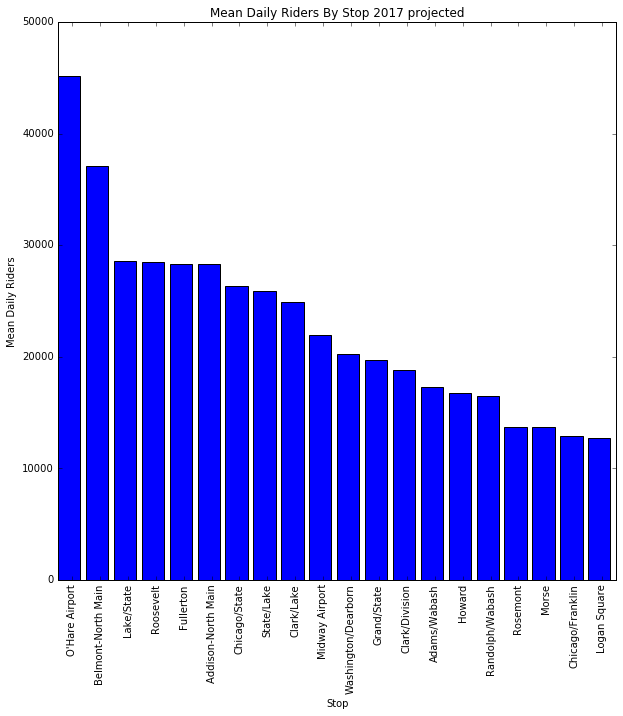

In [158]:
topten(databack[databack.year == 2017],20, extratext = '2017 projected')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


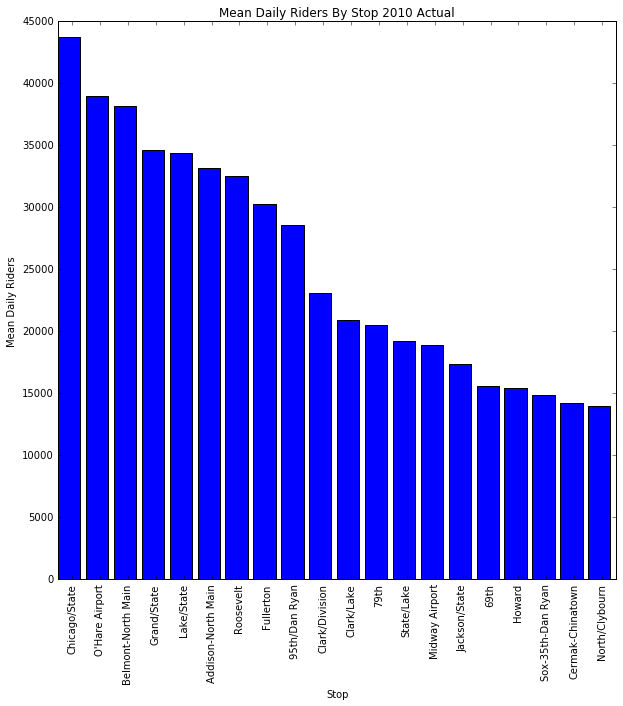

In [187]:
topten(sytotals[sytotals.stationname != 'Total'][sytotals.year == 2010],20, extratext = '2010 Actual')

In [165]:
dfsort = pd.DataFrame(databack.groupby(['stationname','month'], as_index = False)['rides'].mean())
dfsort = dfsort.sort_values(['rides'], ascending = False)[:20]
dfsort

,month,stationname,rides
1138,9.0,O'Hare Airport,63015.080333
1008,8.0,O'Hare Airport,59588.600467
618,5.0,O'Hare Airport,57619.486807
1398,11.0,O'Hare Airport,55669.732830
878,7.0,O'Hare Airport,52968.314704
668,6.0,Belmont-North Main,51810.745066
928,8.0,Belmont-North Main,50113.763112
529,5.0,Addison-North Main,47581.764934
789,7.0,Addison-North Main,47143.789195
1330,11.0,Chicago/State,46728.853612


In [167]:
months = np.arange(1,13)
for month in months:
    dfsort = pd.DataFrame(databack[databack.month == month].groupby(['stationname'], as_index = False)['rides'].mean())
    dfsort = dfsort.sort_values('rides', ascending = False)[:1]

In [173]:
dfsort.stationname.values[0]

"O'Hare Airport"

In [183]:
def monthmaxes(dataframe, extratext = ''):
    months = np.arange(1,13)
    vals = []
    names = []
    for month in months:
        dfsort = pd.DataFrame(dataframe[dataframe.month == month].groupby(['stationname'], as_index = False)['rides'].mean())
        dfsort = dfsort.sort_values('rides', ascending = False)[:1]
        vals.append(dfsort.rides.values[0])
        names.append(dfsort.stationname.values[0])
        
        
    fig, ax = plt.subplots(figsize = [10,10])#


    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(months, vals)

    plt.xlabel('Month')
    plt.ylabel('Mean Daily Riders')
    plt.title('Mean Daily Riders In Highest Traffic Stop Each Month ' + extratext)
    plt.xlim(1,13)
    plt.xticks(months +.5,names, rotation = 90)


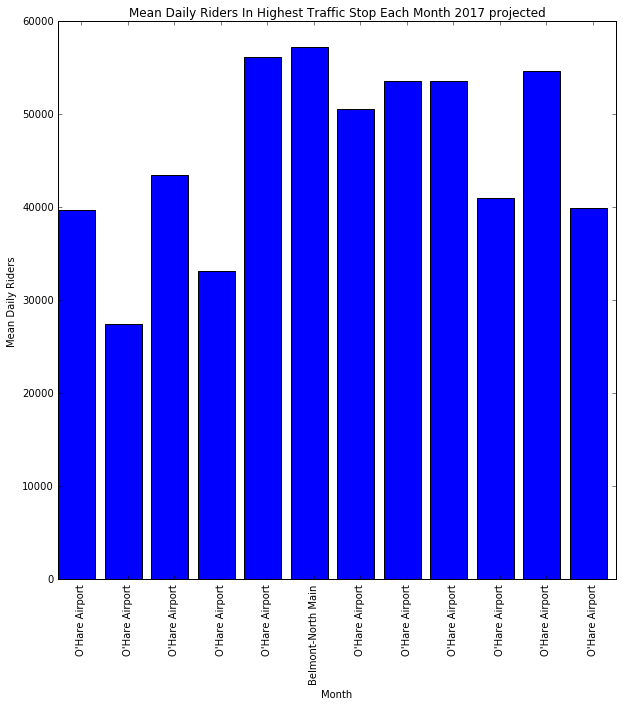

In [184]:
monthmaxes(databack[databack.year == 2017], extratext = '2017 projected')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


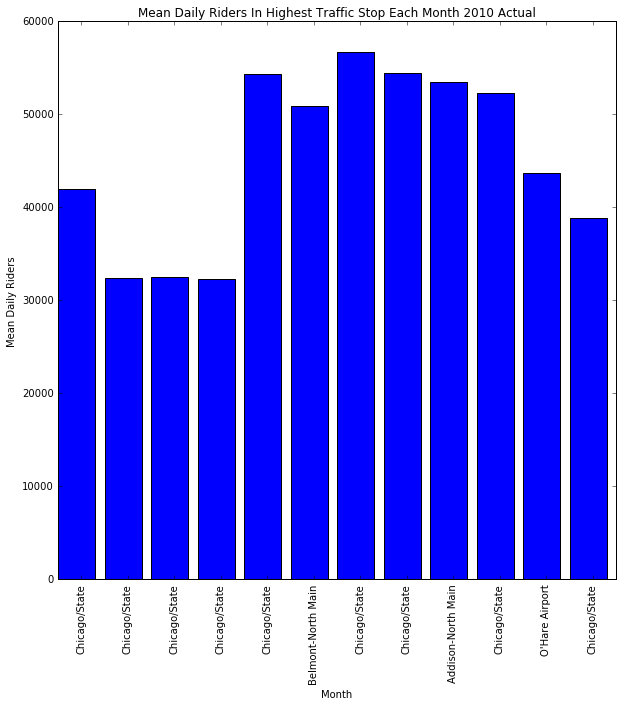

In [186]:
monthmaxes(sytotals[sytotals.stationname != 'Total'][sytotals.year == 2010], extratext = '2010 Actual')